# Lecture et nettoyage des données

## Importation des librairies

In [34]:
import pandas as pd
import numpy as np
import os
import pickle
# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sb
sb.set()
sb.set_style("darkgrid", {"axes.facecolor": ".9"})

## Importation des données

On lit les données d'apprentissage et de test et on forme une liste de toutes les données contenant au total 428 vols.

In [35]:
path_appr = "../Donnees_projet/Ensemble_apprentissage/"
path_test = "../Donnees_projet/Ensemble_de_test/"
#path_appr = "../../4A/Projet/Ensemble d'apprentissage/"
#path_test = "../../4A/Projet/Ensemble de test/"

In [36]:
# Liste des séries d'apprentissage
files = os.listdir(path_appr)
liste_appr = [list(pd.read_csv(path_appr + file)["FF_1"].values) for file in files]
# Liste des séries de test
files = os.listdir(path_test)
liste_test = [list(pd.read_csv(path_test + file)["FF_1"].values) for file in files]
# Liste complète
liste_comp = liste_appr + liste_test
n = len(liste_comp)
ind = list(range(n)) #liste des indices des series

## Visualisation et nettoyage des données

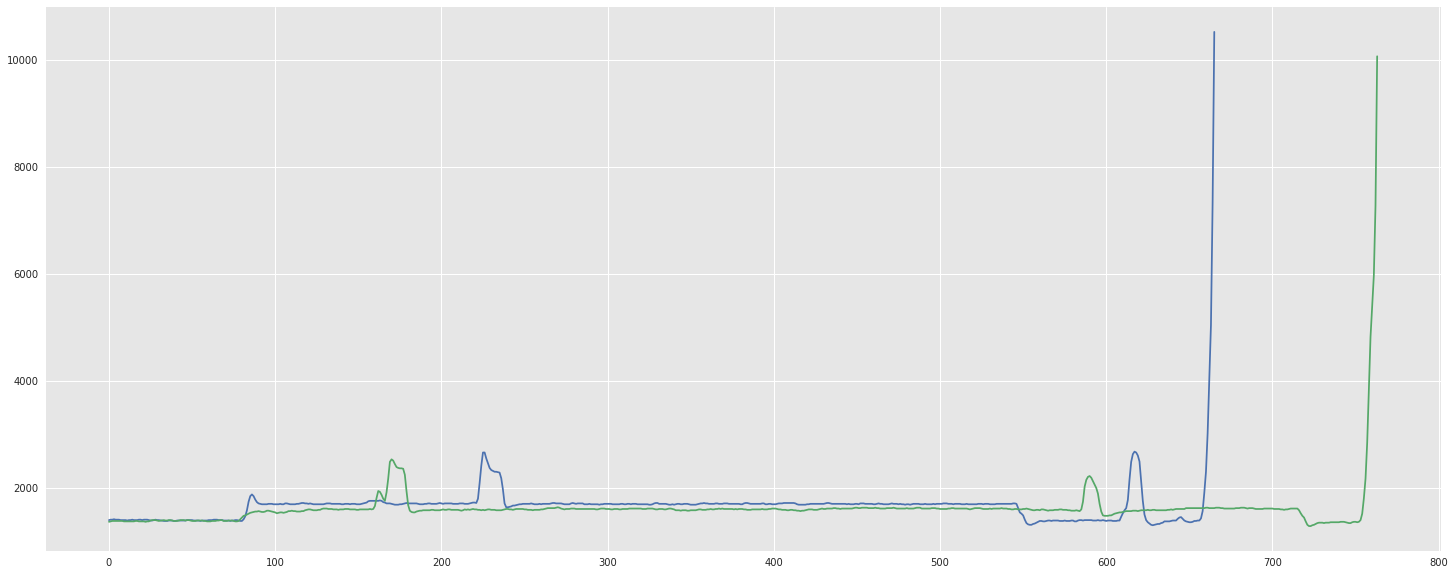

In [38]:
fig = plt.figure(figsize=(25, 10))
for x in liste_comp[5:7] :
    plt.plot(x)
plt.show()

### Suppression des pics finaux

On observe que toutes les séries se terminent par un fort pic. On fait le choix de l'enlever car il n'apporte rien de significatif et risque de perturber l'analyse.

In [5]:
def enlever_pic(serie, seuil=10, pts_moy=2, plot=False) :
    """Retire le pic final, le seuil est le plus petit accroissement considéré comme appartenant
    encore au pic. Les accroissements sont moyennés sur plusieurs points pour ne pas être sensibles 
    aux possibles irrégularités dans le pic.
    L'option plot=True permet de vérifier graphiquement le résultat.
    Retourne la liste tronquée"""
    serie = np.array(serie)
    if plot :
        plt.plot(serie)
        
    accr = abs(serie[1:] - serie[:-1])
    moy_accr = [np.mean(accr[i : i + pts_moy]) for i in range(len(accr) - pts_moy)]

    for ind, val in enumerate(moy_accr[::-1]) :
        if val < seuil and ind >= 1 :
            if plot :
                plt.plot(serie[:-ind], color="red")
                plt.show()
                
            return list(serie[:-ind])
            break
    else : 
        return serie

In [6]:
liste_comp = [enlever_pic(serie) for serie in liste_comp]

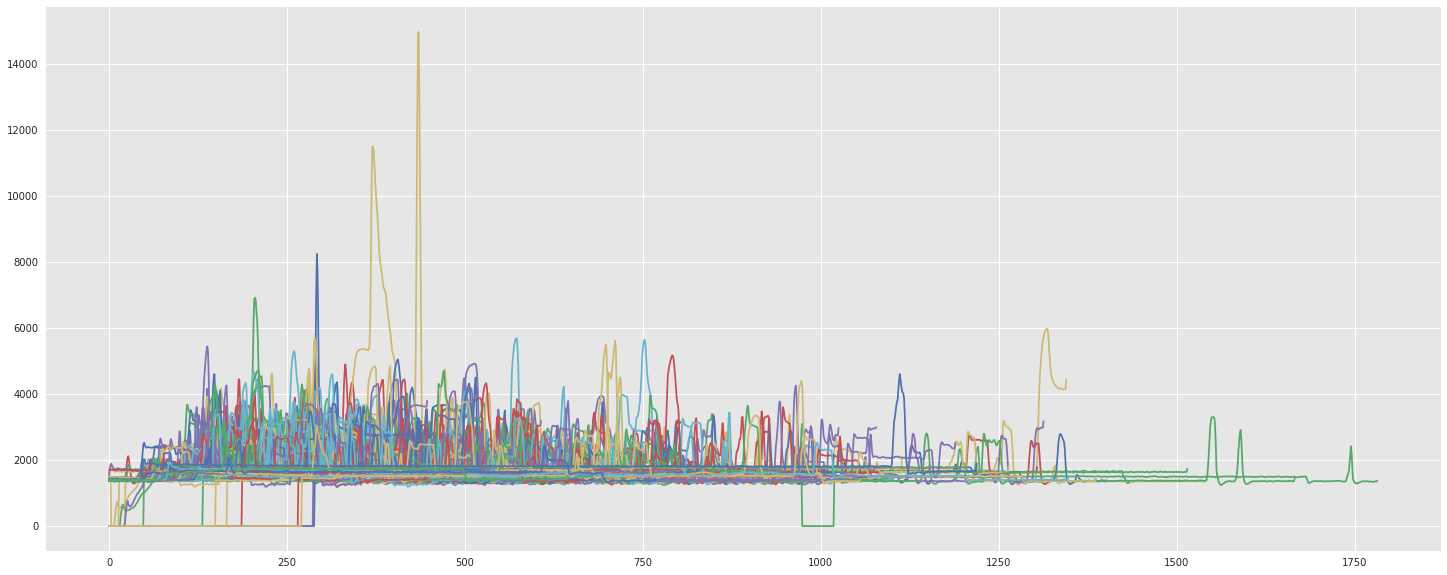

In [7]:
fig = plt.figure(figsize=(25, 10))
for x in liste_comp :
    plt.plot(x)
    
plt.show()

On peut voir qu'on a bien retiré tous les pics finaux.

### Suppression zéros

On enlève maintenant sur les signaux qui commencent à 0 la partie initiale qui doit correspondre au moment où le capteur n'est pas encore activé. 

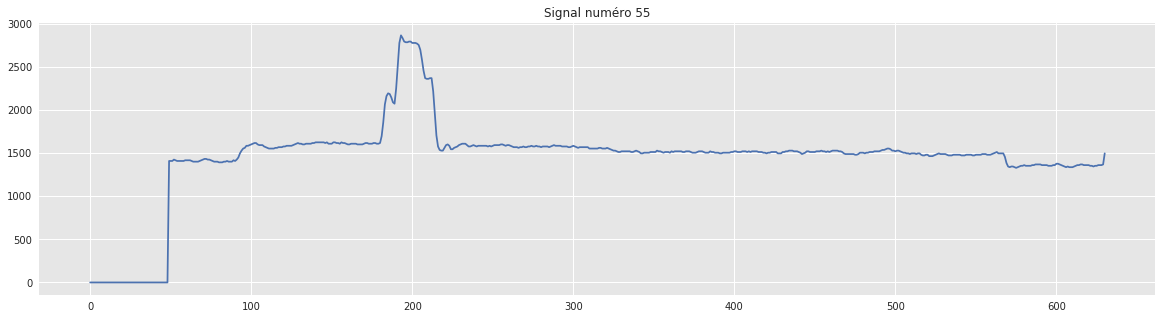

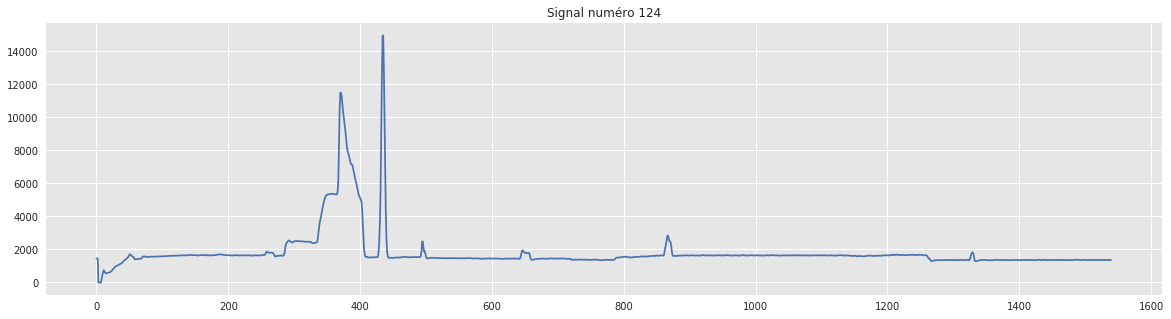

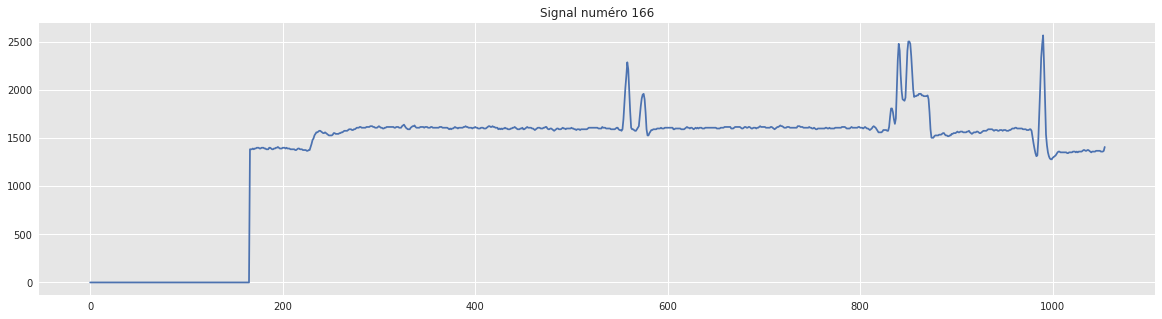

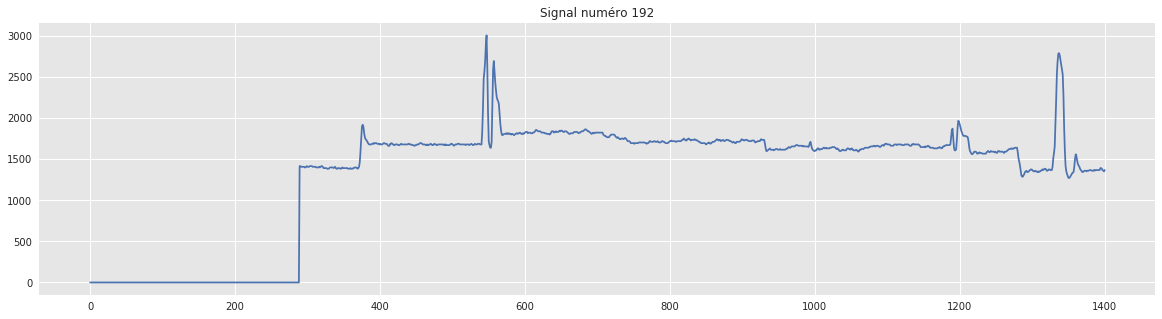

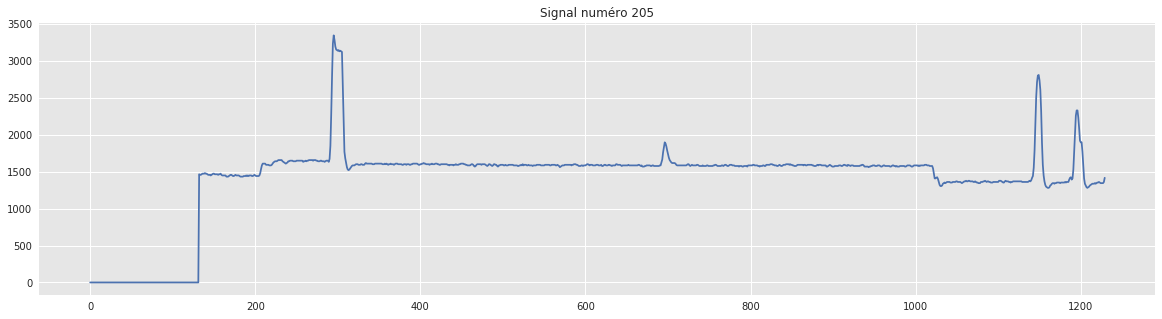

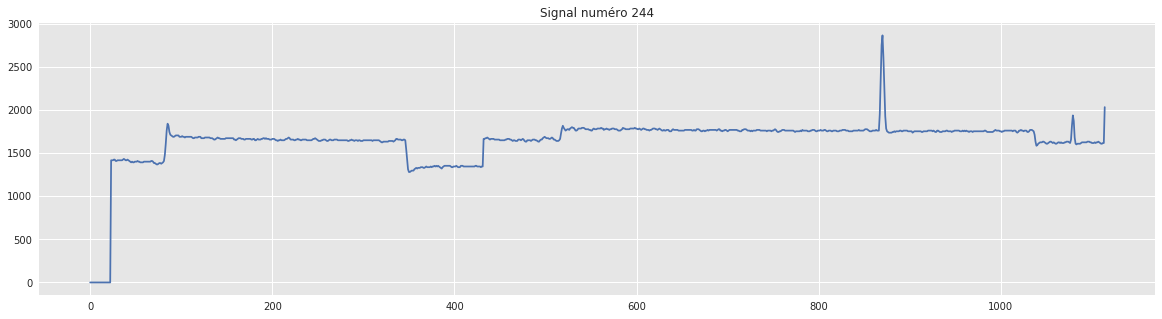

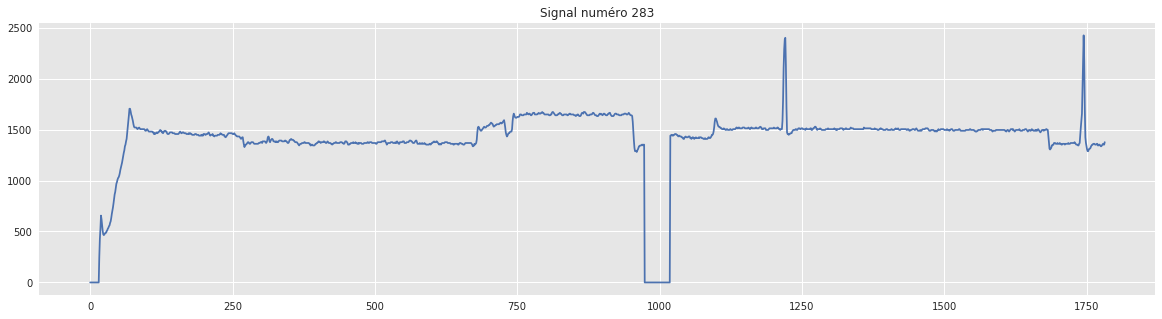

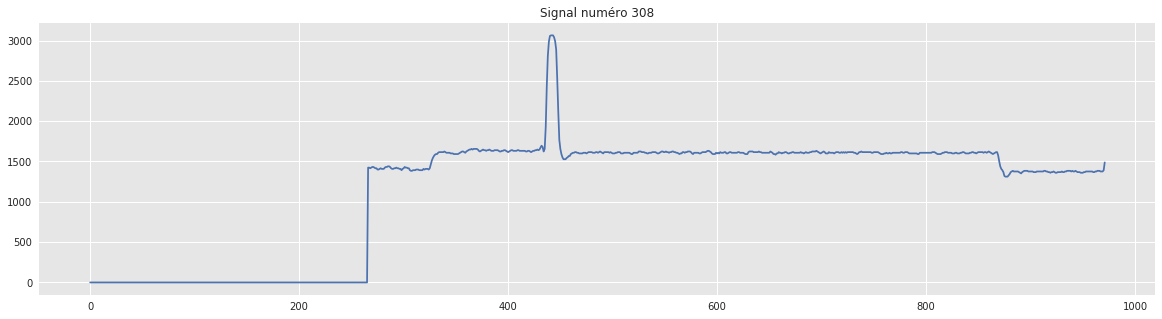

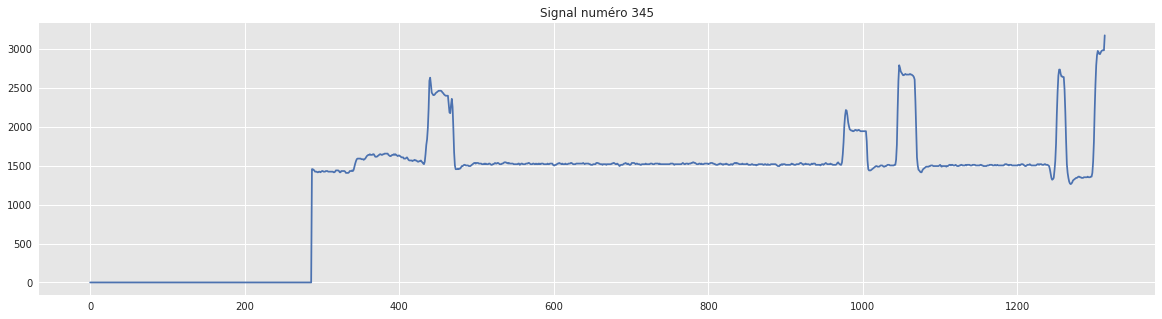

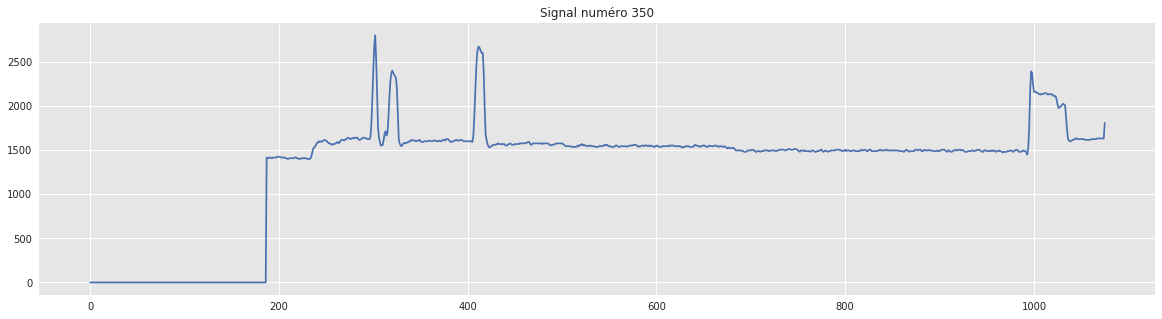

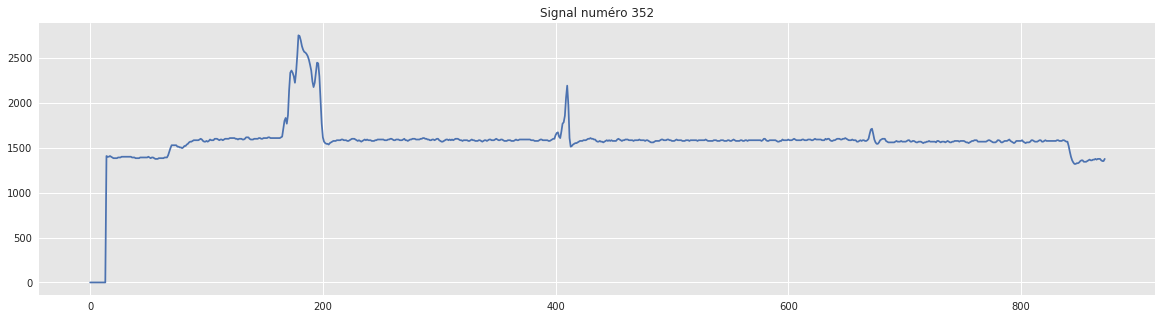

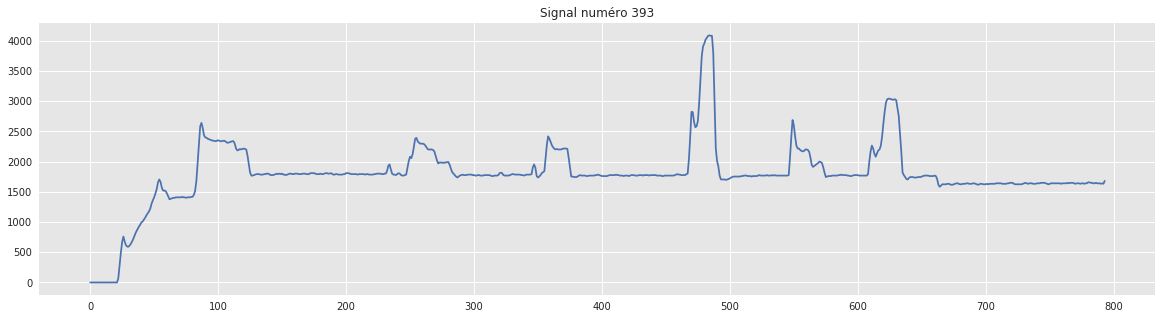

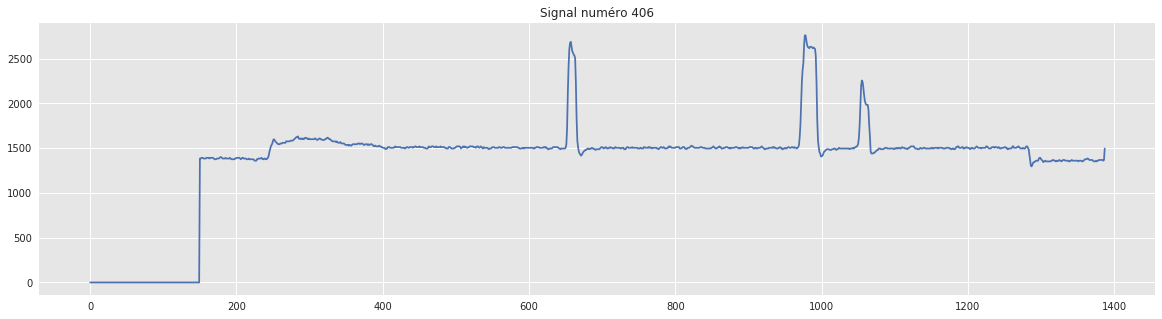

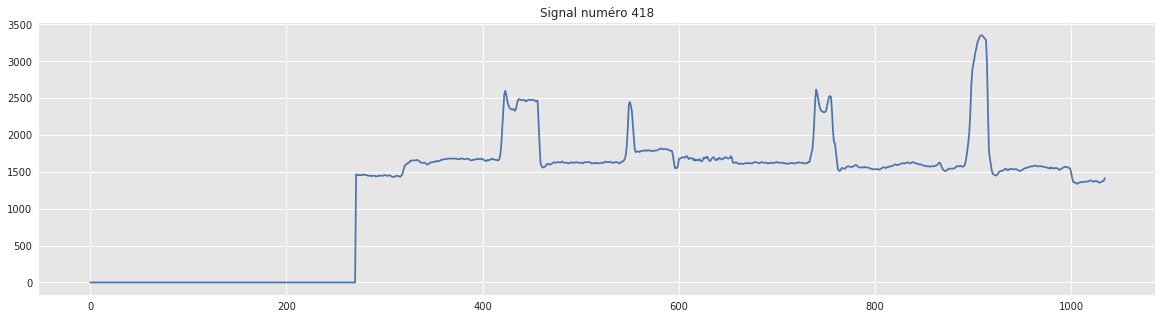

In [8]:
listemin = [min(x) for x in liste_comp]
ind_sig_zero = [i for i, x in enumerate(listemin) if x == 0]

for i in ind_sig_zero :
    fig = plt.figure(figsize=(20, 5))
    plt.plot(liste_comp[i])
    plt.title("Signal numéro " + str(i))
    plt.show()

In [9]:
def enlever_zeros(serie):
    """Renvoie la liste tronquée des valeurs égales à 0"""
    serie = np.array(serie)
    if serie[0] == 0:
        ind_non_zero = np.where(serie > 0, True, False)
        serie = serie[ind_non_zero]
        
    return list(serie)

In [10]:
liste_comp = [enlever_zeros(serie) for serie in liste_comp]

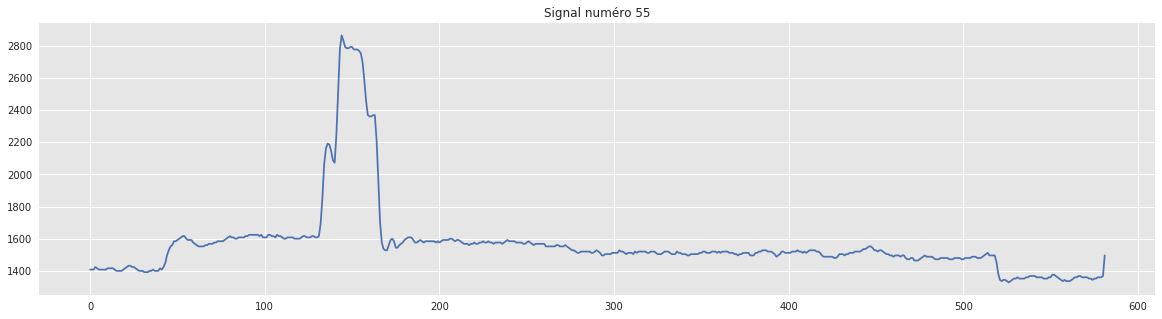

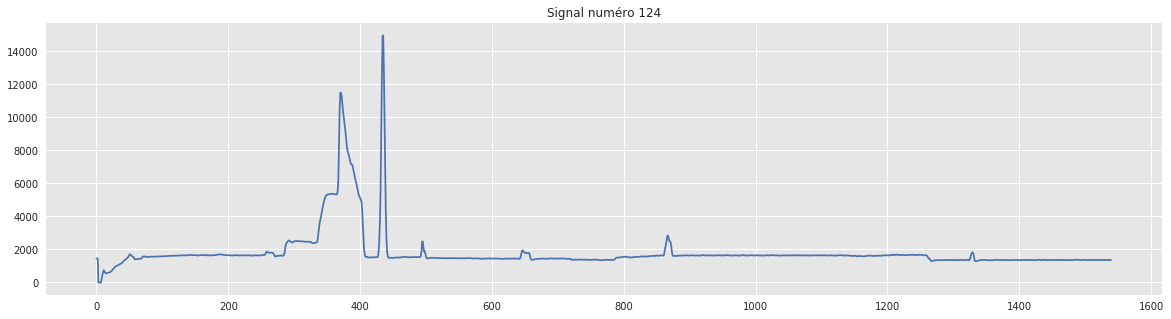

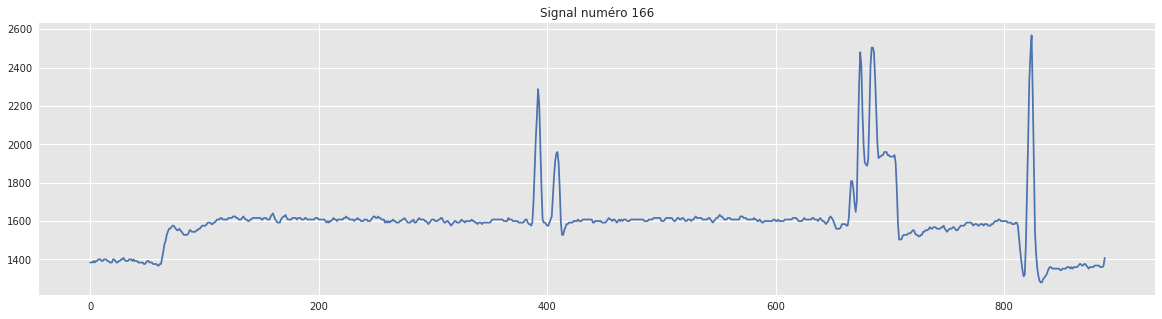

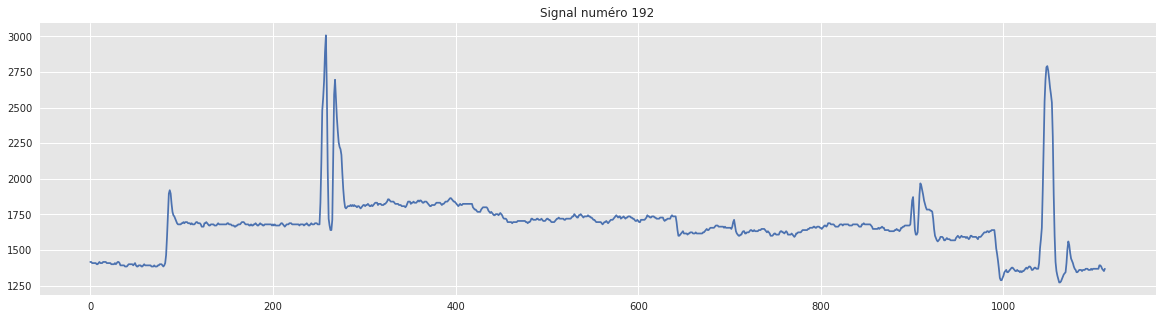

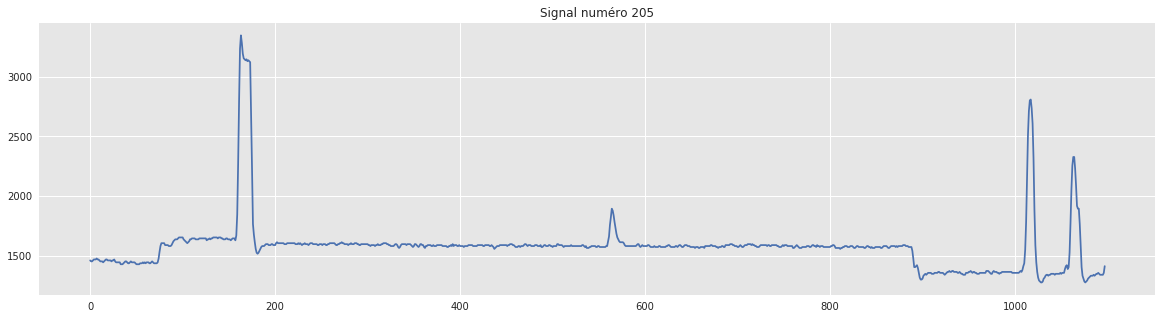

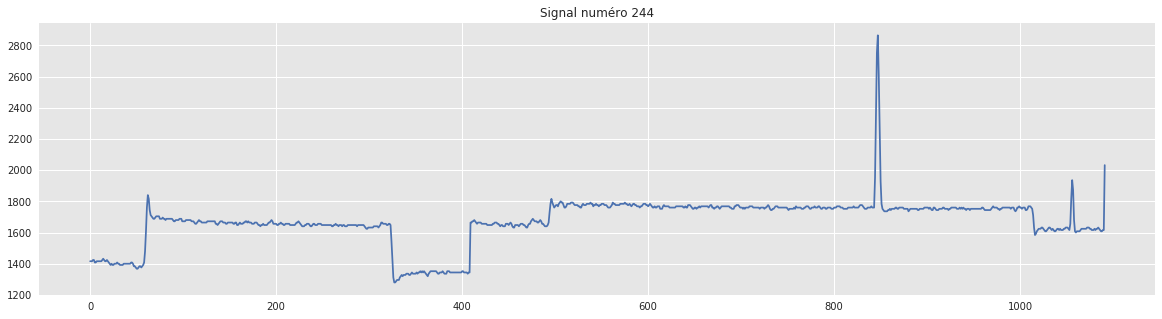

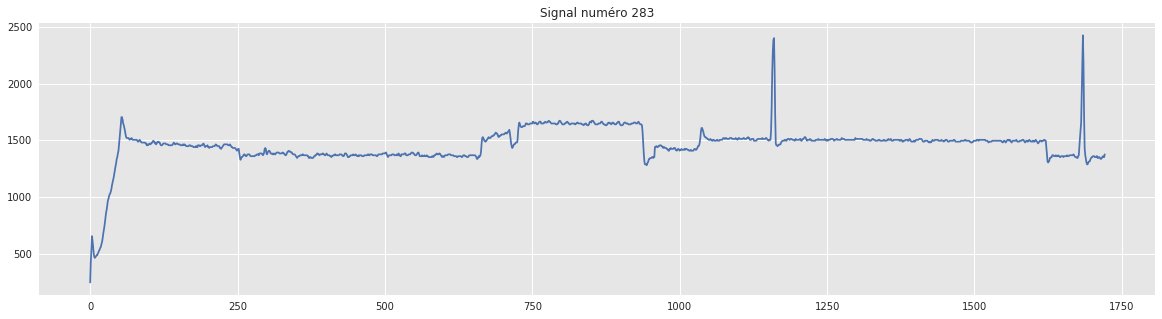

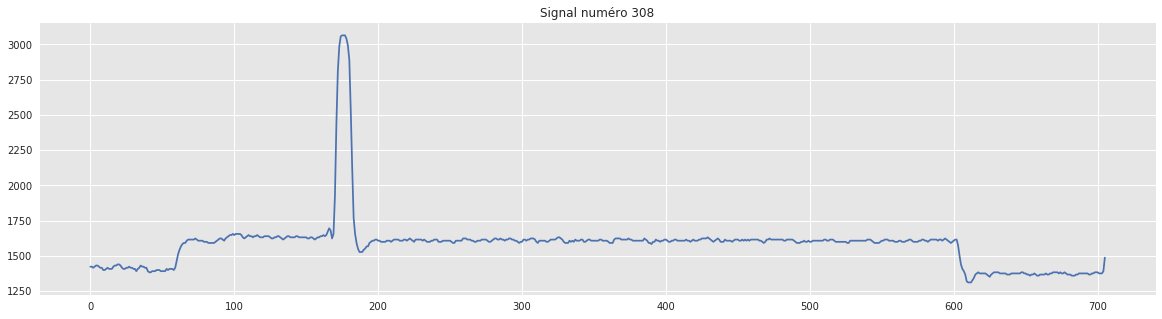

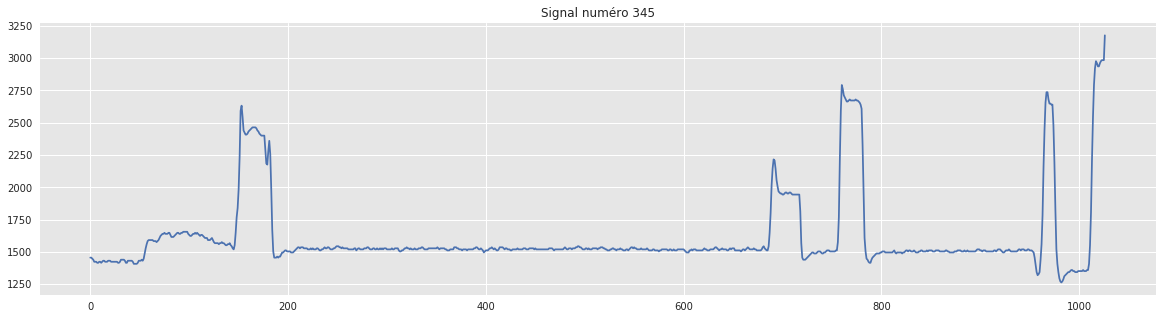

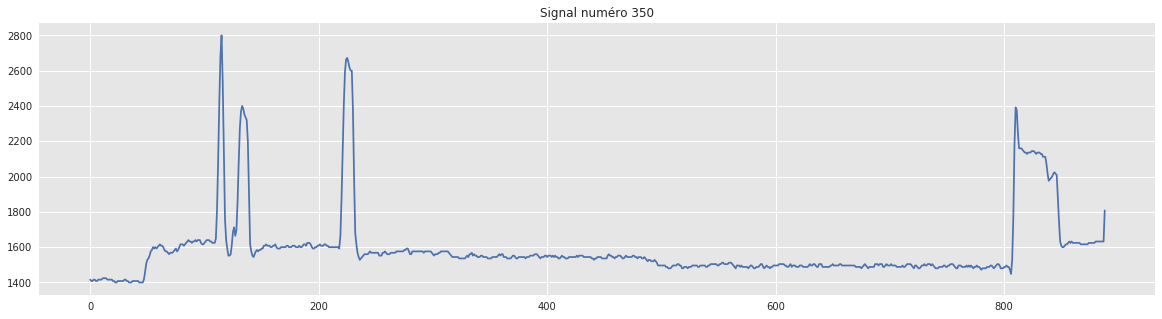

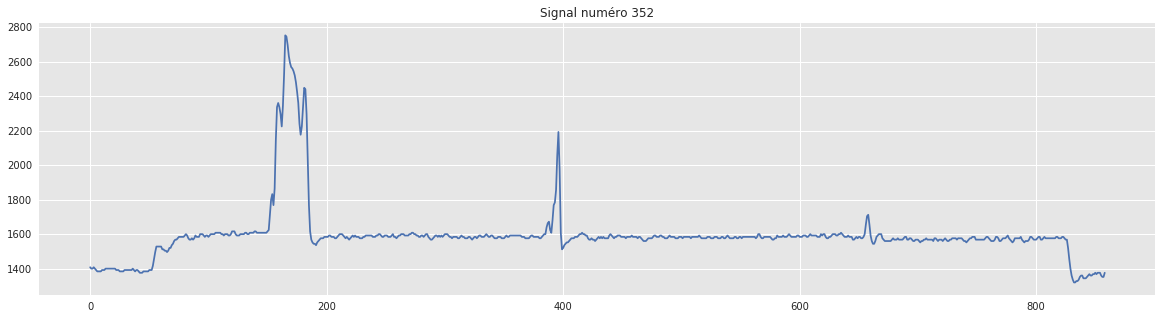

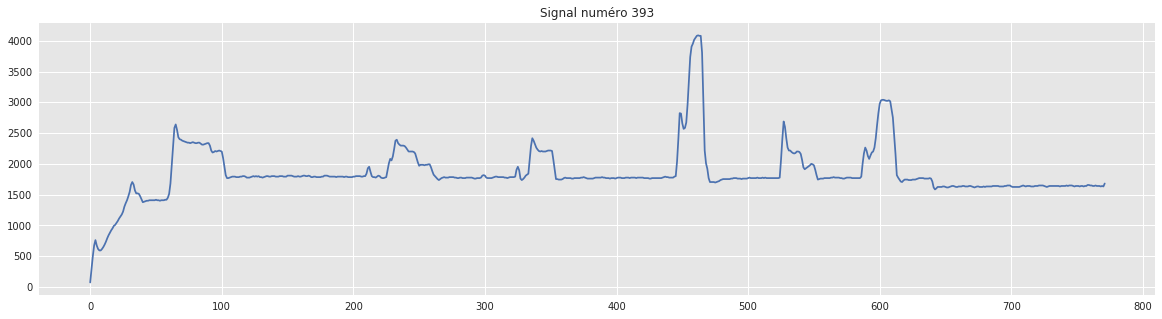

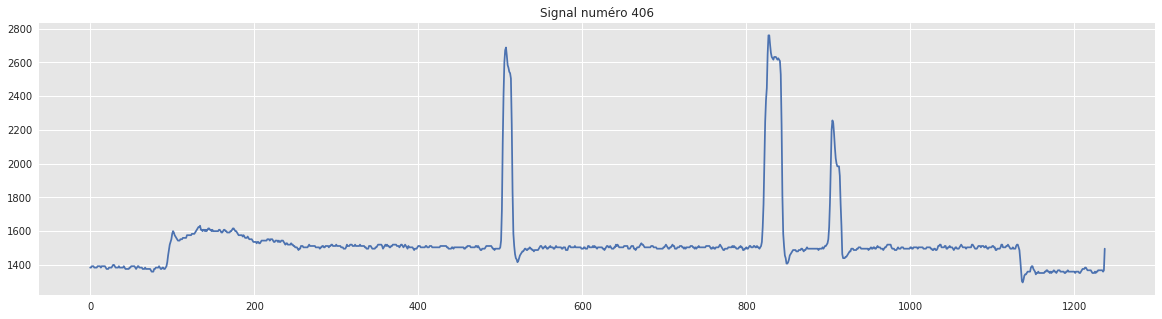

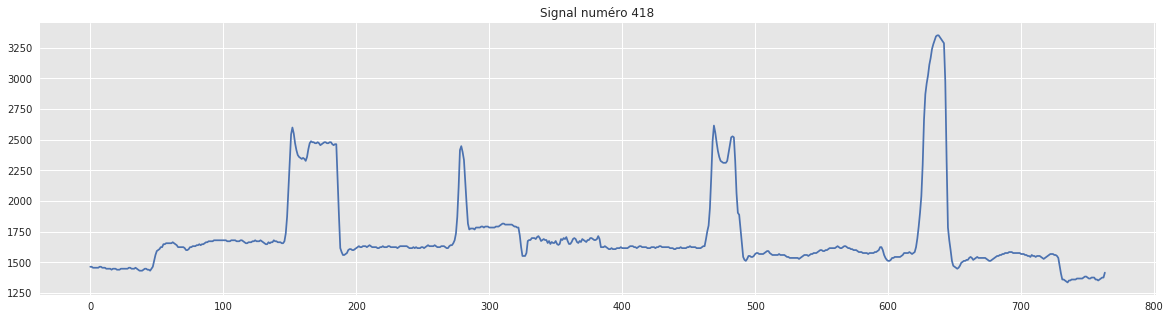

In [11]:
for i in ind_sig_zero :
    fig = plt.figure(figsize=(20, 5))
    plt.plot(liste_comp[i])
    plt.title("Signal numéro " + str(i))
    plt.show()

### Suppression des signaux avec des pics trop grands

De plus, nous faisons le choix de supprimer les signaux possédant de trop forts pics. 

In [12]:
# Piste d'amélioration : calcul automatique du seuil

def suppr_forts_pics(serie, seuil=6000):
    """Renvoie True si la série doit être supprimée car contient un pic suspect."""
    serie = np.array(serie)
    return (serie > seuil).any()

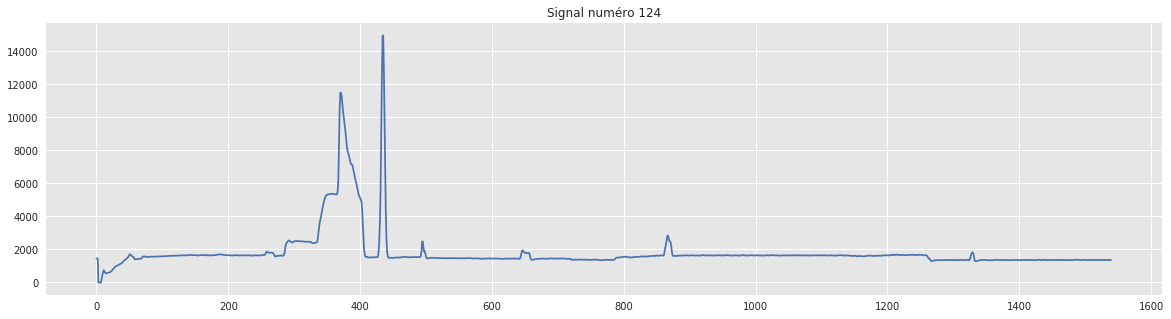

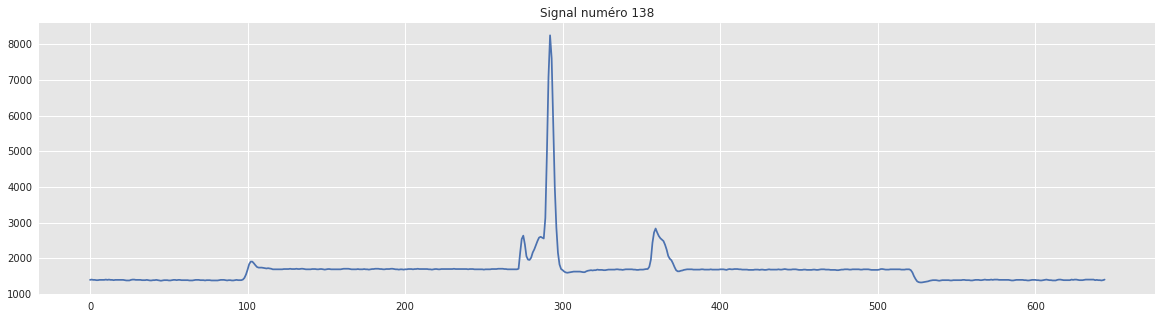

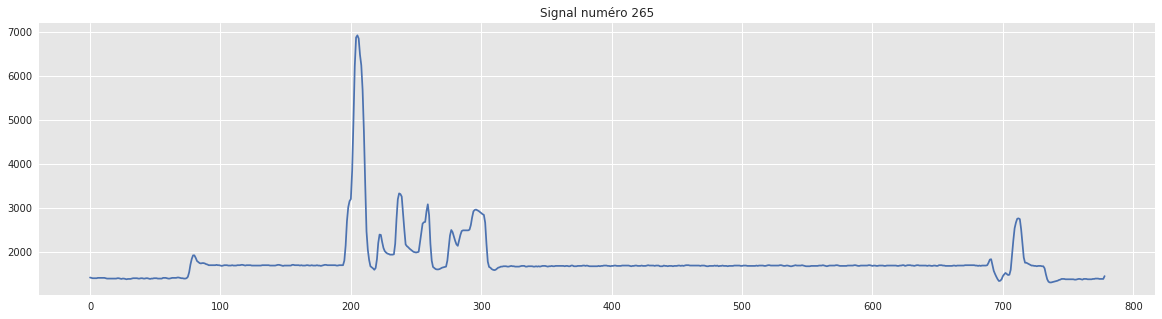

In [13]:
for i,x in enumerate(liste_comp) :
    if suppr_forts_pics(x):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(liste_comp[i])
        plt.title("Signal numéro " + str(i))
        plt.show()

Ci-dessus les 3 signaux possédant des forts pics qui semblent suspects pour l'analyse des données.

In [14]:
print('nombre de signaux : ',len(liste_comp))

nombre de signaux :  428


In [15]:
#on recupere les indices des signaux a supprimer
ind_a_suppr = [i for i, serie in enumerate(liste_comp) if suppr_forts_pics(serie)] 
print('indices des signaux à supprimer : ',ind_a_suppr)
#on enleve ces indices de la liste d'indices
for i in ind_a_suppr :
    ind.remove(i)

indices des signaux à supprimer :  [124, 138, 265]


In [16]:
#on supprime les signaux
for i,serie in enumerate(liste_comp):
    if suppr_forts_pics(serie):
        del liste_comp[i]
print('nombre de signaux : ',len(liste_comp))

nombre de signaux :  425


On stocke les signaux nettoyés dans un fichier :

In [17]:
# Ecrire dans un fichier
with open('liste_propre', 'wb') as fichier:
    mon_pickler = pickle.Pickler(fichier)
    mon_pickler.dump((liste_comp, ind))

### Visualisation après nettoyage

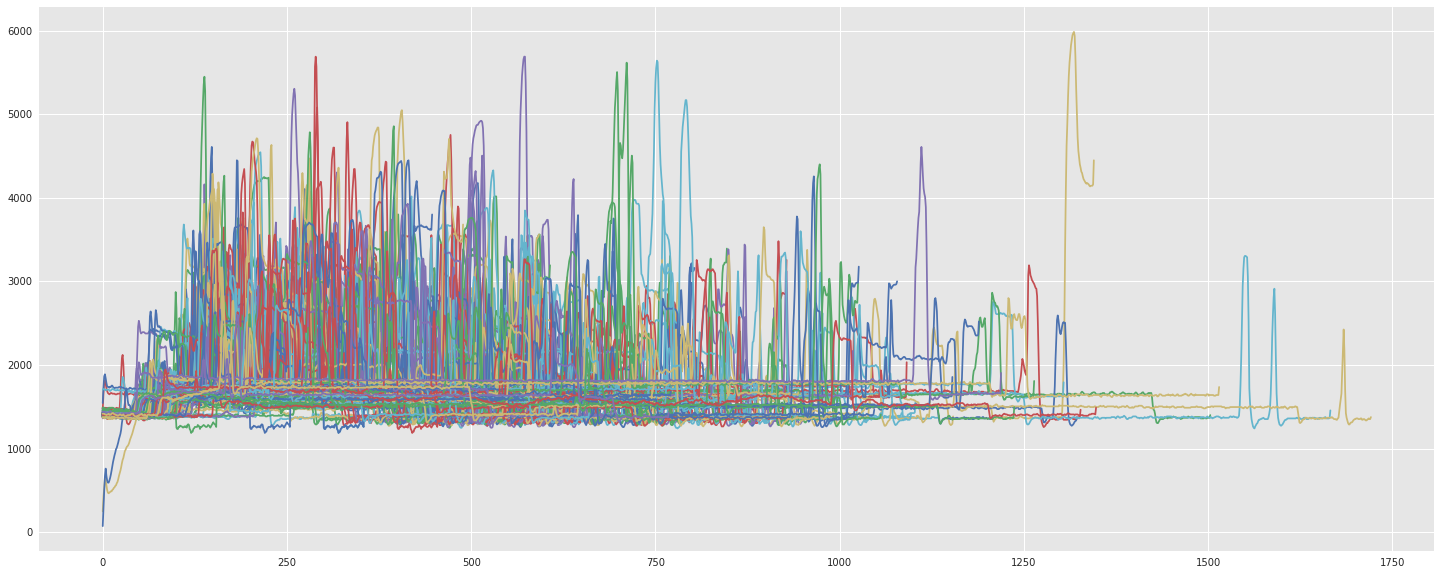

In [18]:
fig = plt.figure(figsize=(25, 10))
for x in liste_comp :
    plt.plot(x)   
plt.show()

**Q** On enlève aussi ceux qui commencent proches de zéro ? Et celui avec un grand pic à la fin?

Longueur des séries après nettoyage :

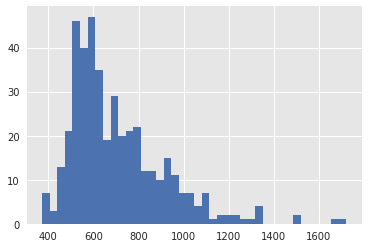

longueur min :  372


In [19]:
long = [len(serie) for serie in liste_comp]
plt.hist(long,bins=40)
plt.show()
longueur_min = min(long)
print('longueur min : ', longueur_min)

## Traitement des données

Afin d'utiliser toutes les méthodes de transformation et de détection d'anomalies sur nos données, nous devons mettre toutes les données à la même longueur. Nous choississons 1024 comme longueur afin d'utiliser au mieux les données après transformation en ondelettes.

Pour les signaux dont la longueur est supérieure à 1024, nous tronquons le signal. Pour ceux dont la longueur est plus petite que 1024, nous pouvons utiliser le zéro-padding ou nous pouvons symétriser le signal pour l'agrandir et le tronquer ensuite. Ici nous allons utiliser la 2ème méthode.

In [20]:
def to1024(serie):
    """Renvoie la série agrandie ou tronquée à une longueur de 1024"""
    x=serie.copy() #pour ne pas modifier list_comp
    while len(x)<1024:
        x.extend(x[::-1]) #ajoute la liste inversée
    return x[:1024]      

In [21]:
liste_comp_1024 = [to1024(serie) for serie in liste_comp]

Text(0.5,1,'Signal 278 après to1024')

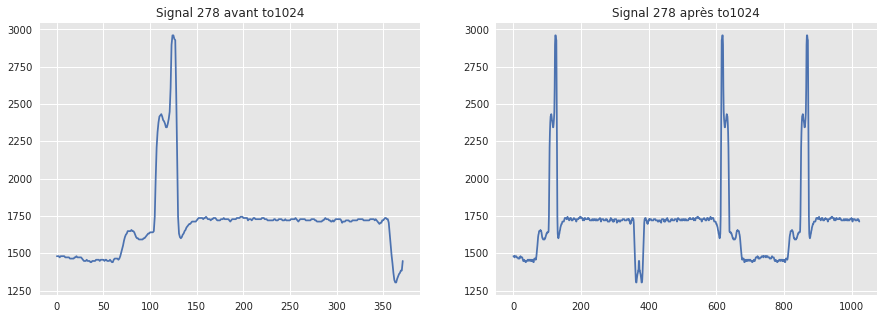

In [22]:
for i,x in enumerate(liste_comp):
    if len(x)==372:
        ind_min = i
        
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
plt.plot(liste_comp[ind_min])
ax.set_title("Signal " + str(ind_min) + " avant to1024")
ax = fig.add_subplot(1,2,2)
plt.plot(liste_comp_1024[ind_min]) 
ax.set_title("Signal " + str(ind_min) + " après to1024")

In [23]:
k=0
for x in liste_comp :
    if len(x)<512:
        k+=1
print("Nb de signaux de taille < à 512 : ", k)

Nb de signaux de taille < à 512 :  49


**Q** Pour des signaux de taille < à 512, est ce bien correct de faire plusieurs symétries avant de tronquer ?

### Visualisation après traitement

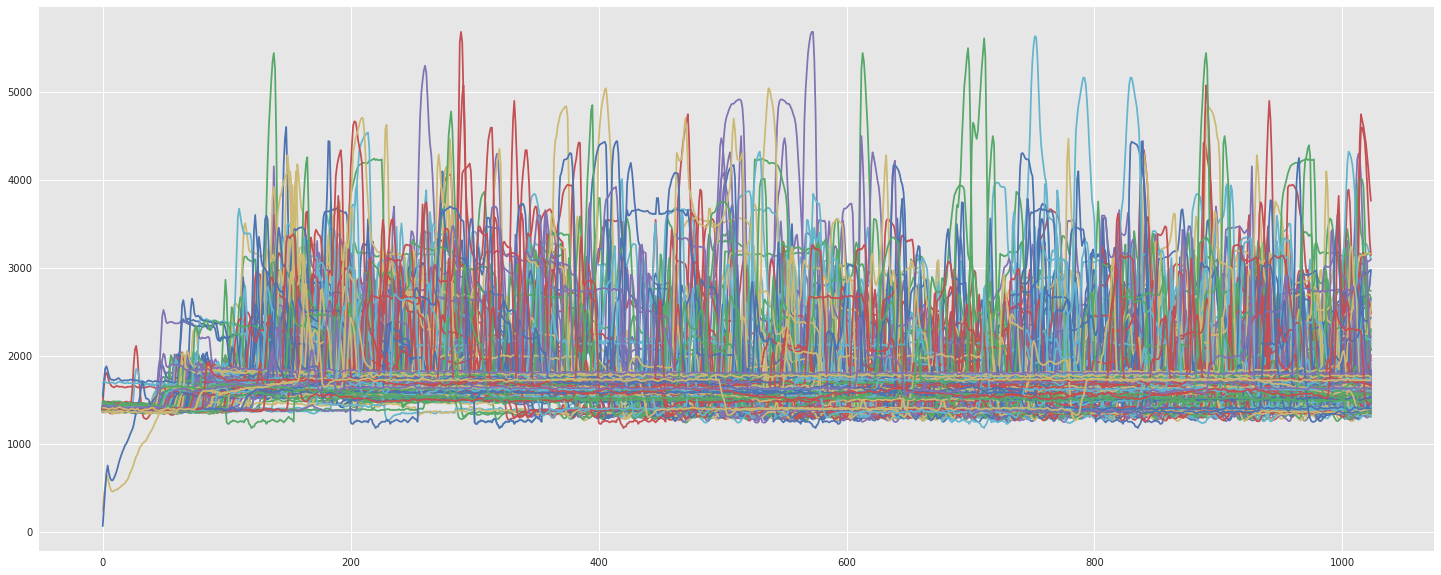

In [24]:
fig = plt.figure(figsize=(25, 10))
for x in liste_comp_1024 :
    plt.plot(x)   
plt.show()

## Ecrire et lire un fichier

In [25]:
import pickle

In [26]:
# Ecrire dans un fichier
with open('X_1024', 'wb') as fichier:
    mon_pickler = pickle.Pickler(fichier)
    mon_pickler.dump((liste_comp_1024, ind))

In [27]:
#Lire un fichier
with open('X_1024', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    X_1024_recupere, ind_recupere = mon_depickler.load()

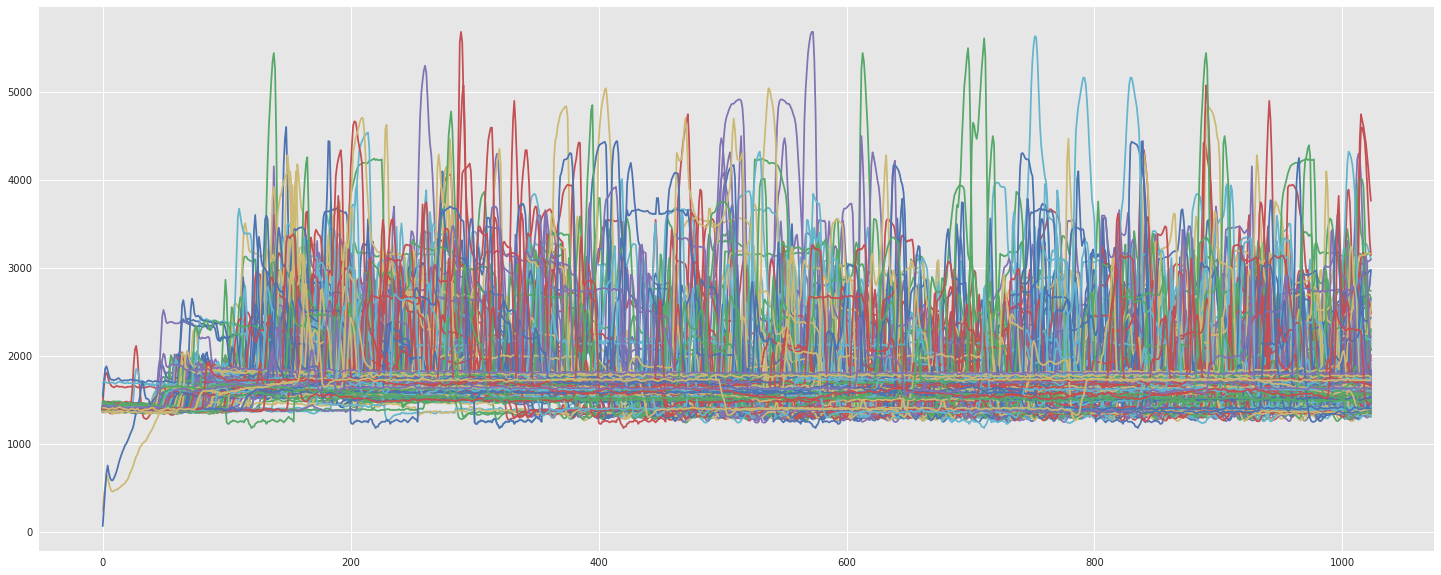

In [28]:
fig = plt.figure(figsize=(25, 10))
for x in X_1024_recupere:
    plt.plot(x)

In [29]:
print(ind_recupere)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,

In [30]:
print(X_1024_recupere[0])

[1416.0, 1416.0, 1416.0, 1416.0, 1424.0, 1424.0, 1416.0, 1408.0, 1400.0, 1408.0, 1408.0, 1408.0, 1408.0, 1408.0, 1408.0, 1408.0, 1408.0, 1416.0, 1408.0, 1408.0, 1408.0, 1400.0, 1392.0, 1392.0, 1400.0, 1400.0, 1392.0, 1392.0, 1384.0, 1392.0, 1392.0, 1392.0, 1392.0, 1384.0, 1392.0, 1400.0, 1408.0, 1408.0, 1408.0, 1408.0, 1440.0, 1496.0, 1544.0, 1576.0, 1600.0, 1608.0, 1616.0, 1616.0, 1616.0, 1616.0, 1624.0, 1624.0, 1608.0, 1600.0, 1584.0, 1584.0, 1576.0, 1568.0, 1576.0, 1584.0, 1584.0, 1592.0, 1584.0, 1576.0, 1576.0, 1592.0, 1600.0, 1600.0, 1592.0, 1592.0, 1608.0, 1608.0, 1616.0, 1608.0, 1608.0, 1608.0, 1616.0, 1608.0, 1616.0, 1624.0, 1632.0, 1640.0, 1640.0, 1640.0, 1648.0, 1648.0, 1648.0, 1632.0, 1640.0, 1632.0, 1640.0, 1648.0, 1656.0, 1648.0, 1648.0, 1648.0, 1648.0, 1656.0, 1656.0, 1656.0, 1648.0, 1640.0, 1632.0, 1640.0, 1640.0, 1640.0, 1640.0, 1640.0, 1640.0, 1648.0, 1656.0, 1656.0, 1648.0, 1648.0, 1656.0, 1656.0, 1656.0, 1656.0, 1656.0, 1648.0, 1648.0, 1640.0, 1648.0, 1640.0, 1640.0,

Récupération des listes apprentissage et test :

In [31]:
liste_appr = list(np.asarray(X_1024_recupere)[np.asarray(ind_recupere) <= 299])
liste_test = list(np.asarray(X_1024_recupere)[np.asarray(ind_recupere) > 299])
print(len(liste_appr))
print(len(liste_test))

297
128
